w_shape:(1025, 120)
x_data.shape:(48510, 2)
thre_index_key:33652
keystroke_x.shape:(9000, 2)
noise_x.shape:(39510, 2)
round 0, error:713.0879294055815
round 50, error:32.90387654233866
round 0, error:720.5399876402256
round 50, error:37.26758620695562
extracted_x_list.shape:(2, 48128)


original sound


denoised sound


noise


reconstuction


(2, 48510)


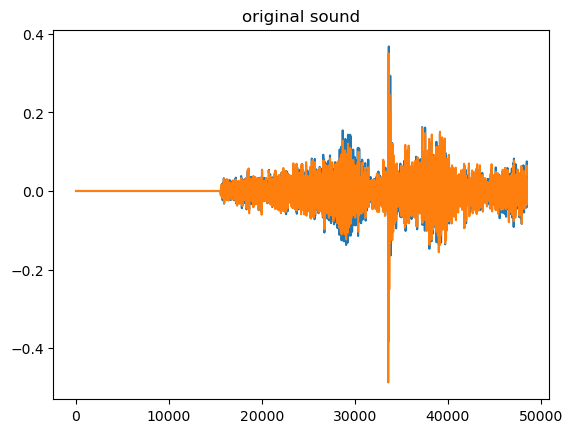

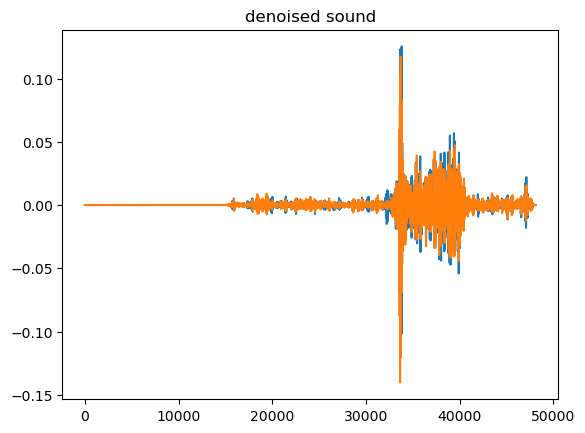

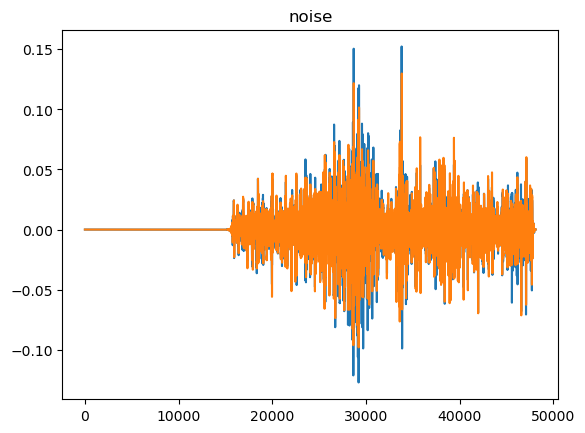

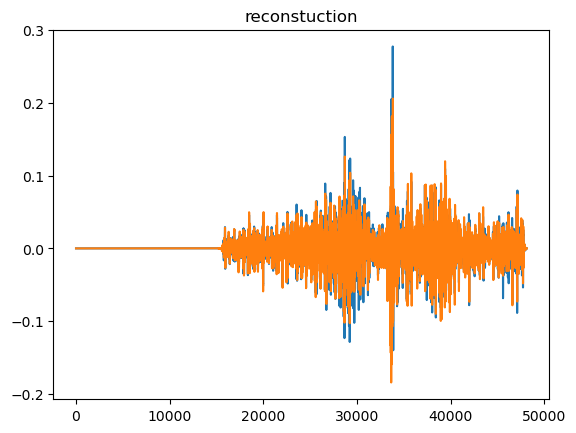

x_data.shape:(48510, 2)
thre_index_key:33465
keystroke_x.shape:(9000, 2)
noise_x.shape:(39510, 2)
round 0, error:707.7346241046779
round 50, error:25.221245303133877
round 0, error:716.3435622883284
round 50, error:27.31950644985396
extracted_x_list.shape:(2, 48128)


original sound


denoised sound


noise


reconstuction


(2, 48510)


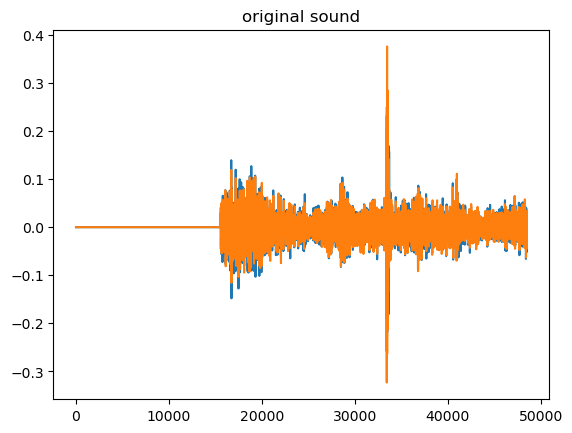

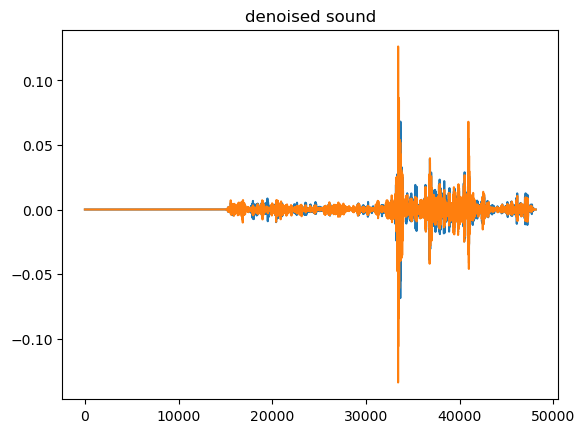

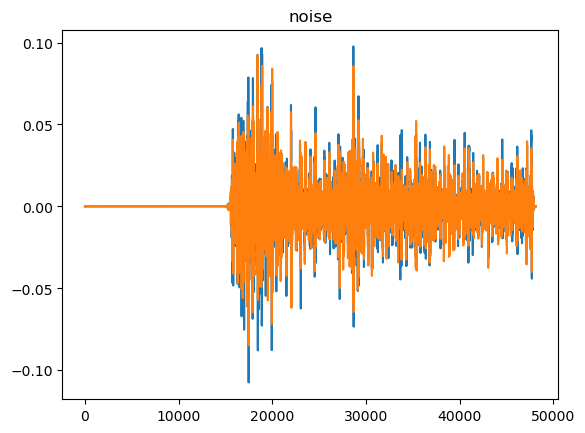

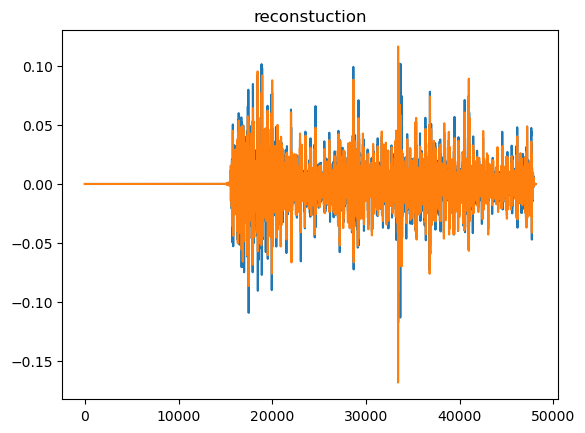

x_data.shape:(48510, 2)
thre_index_key:33487
keystroke_x.shape:(9000, 2)
noise_x.shape:(39510, 2)
round 0, error:702.5550709530676
round 50, error:25.584589364496114
round 0, error:713.0996449876911
round 50, error:28.773866438156876
extracted_x_list.shape:(2, 48128)


original sound


denoised sound


noise


reconstuction


(2, 48510)


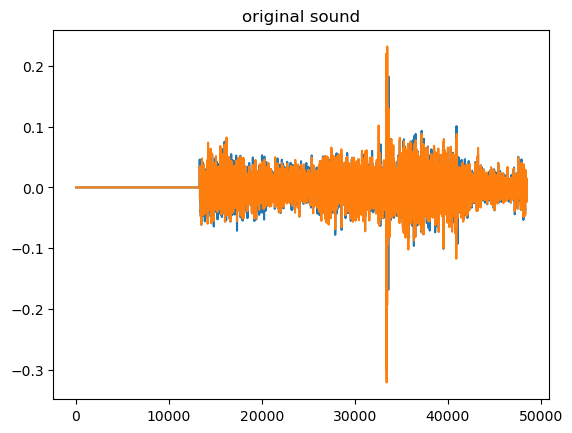

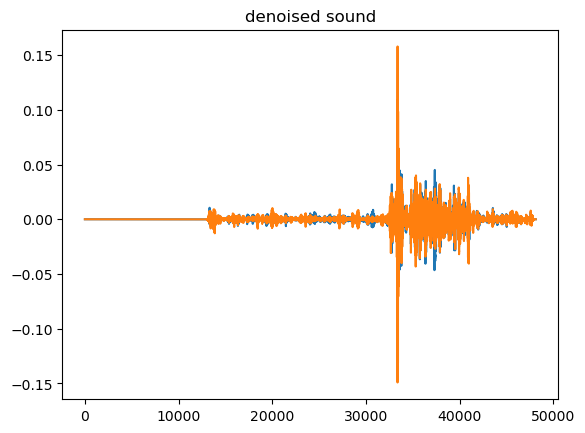

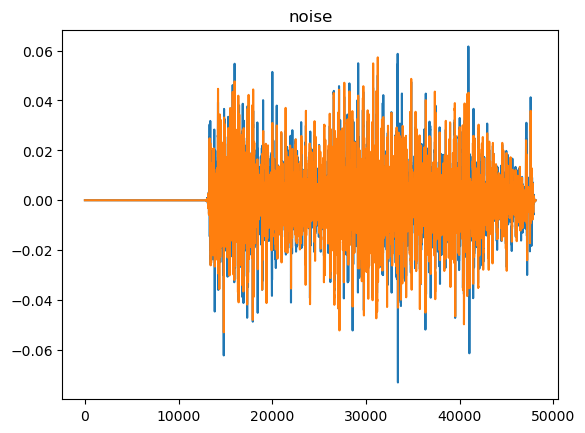

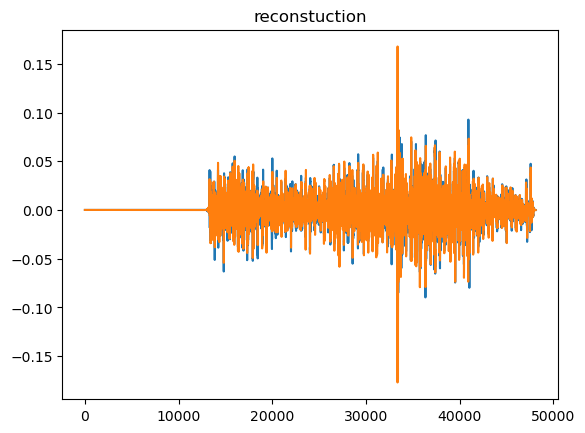

In [14]:
from keystroke_libfiles import *


'''
This file take w (frequency factor) matrix to perform denoise on given file or directory of file
'''

w_filepath = "denoise_model/w_kb1_noise1.1_1100ms.npz"
data_filepath = "records/kb1_noise_test/"



# function to train the w and h based on given stft data
def standard_train(x_stft,k):
    # initialize f, w ,and h matrices
    epsilon = 1e-7
    rng = np.random.default_rng()
    f = np.abs(x_stft).T
    m,n = np.shape(f)
    w = rng.random((m,k))+10
    h = rng.random((k,n))+10

    # iterate the learning process
    iter_num = 100
    for i in range(iter_num):
        reconstruction = np.dot(w, h)
        v = f/(reconstruction+epsilon)
        h = h*np.dot(w.T,v)
        w = w*np.dot(v,h.T)
        w = w / np.sum(w, axis=0)

        # error = np.linalg.norm(f - reconstruction, 'fro')  # Frobenius norm
        # if i%20 == 0:
        #     print(f"round {i}/{iter_num}. error:{error}")
    return w,h


def denoise_data(w_filepath, data_filepath):

    # stft step
    dft_size = 1024
    hop_size = int(2/4 * dft_size)
    zero_pad = dft_size
    window = np.hamming(dft_size)
    epsilon = 1e-7

    
    w_feature = np.load(w_filepath)['x']
    w_shape = w_feature.shape
    print(f"w_shape:{w_shape}")

    file_list = data_filepath.split("/")

    if not os.path.exists("record_denoised/"):
        os.makedirs("record_denoised/")

    if not os.path.exists(f"record_denoised/{file_list[-2]}/"):
        os.makedirs(f"record_denoised/{file_list[-2]}/")

    rng = np.random.default_rng()
    

    count = 0
    for file in os.listdir(data_filepath):

        sr, x_data = wavreadlocal(data_filepath+file)

        
        print(f"x_data.shape:{x_data.shape}")

        thre_index_key = find_thre_index(x_data,1.01)

        print(f"thre_index_key:{thre_index_key}")
        
        keystroke_x = x_data[thre_index_key-1000: thre_index_key+8000, :]
        noise_x = np.concatenate((x_data[:thre_index_key-1000, :], x_data[thre_index_key+8000:, :]), axis=0)
        # noise_x = x_data[:thre_index_key-1000, :] + x_data[thre_index_key+8000:, :]

        print(f"keystroke_x.shape:{keystroke_x.shape}")
        print(f"noise_x.shape:{noise_x.shape}")

        x_data = np.array(x_data).T
        noise_x = np.array(noise_x).T

        x_stft_list = []
        noise_stft_list = []

        for channel in x_data:
            x_stft_list.append(stft(input_sound = channel,dft_size = dft_size, hop_size = hop_size, zero_pad = zero_pad, window = window))

        for channel in noise_x:
            noise_stft_list.append(stft(input_sound = channel,dft_size = dft_size, hop_size = hop_size, zero_pad = zero_pad, window = window))

        # compute original phase of the mix sound
        extracted_x_list = []
        extracted_noise_list = []
        reconstuct_list = []

        for i in range(len(x_stft_list)):
            x_stft = x_stft_list[i]
            noise_stft = noise_stft_list[i]

            original_phase = np.exp(1j * np.angle(x_stft))

            k_noise = 40
            # w_noise = rng.random((w_shape[0],k_noise))+10
            w_noise, h_noise = standard_train(noise_stft, 20)
            # print(f"w_feature.shape:{w_feature.shape}")
            # print(f"w_noise.shape:{w_noise.shape}")
            w_mix = np.hstack((w_feature,w_noise))
            # print(f"w_mix.shape:{w_mix.shape}")
            f = np.abs(x_stft).T
            m,n = np.shape(f)
            h_mix = rng.random((w_mix.shape[1],n))+10
            # print(f"h_mix.shape:{h_mix.shape}")

            # train and learn h matrix with fixed w matrix
            for i in range(100):

                # w_mix = np.hstack((w_feature,w_noise))
                # w_mix = w_mix / np.sum(w_mix, axis=0)
                reconstruction = np.dot(w_mix,h_mix)
                v = f/(reconstruction+epsilon)
                h_mix = h_mix*np.dot(w_mix.T,v)
                # w_mix = w_mix*np.dot(v,h_mix.T)
                # w_mix = w_mix / np.sum(w_mix, axis=0)
                # w_noise = w_mix[:,-k_noise:]

                
                error = np.linalg.norm(f - reconstruction, 'fro')  # Frobenius norm

                if i % 50 == 0:
                    print(f"round {i}, error:{error}")

            extracted_stft_x = np.zeros_like(x_stft).T
            extracted_noise_x = np.zeros_like(x_stft).T
            # extract each component of the sound
            # for i in range(w_shape[1]):
            #     index = i
            #     # single_x_stft = np.outer(w_mix.T[index],h_mix[index])*original_phase.T
            #     print(f"np.dot(w_mix.T[:index],h_mix[:index]).shape:{np.dot(w_mix.T[:index,:],h_mix[:index,:]).shape}")
            #     single_x_stft = np.dot(w_mix[:,:index],h_mix[:index,:])*original_phase.T
            #     extracted_stft_x += single_x_stft
            # print(f"w_mix[:,:w_shape[1]].shape:{w_mix[:,:w_shape[1]].shape}")
            # print(f"h_mix[:w_shape[1],:].shape:{h_mix[:w_shape[1],:].shape}")
            # print(f"np.dot(w_mix[:,:w_shape[1]],h_mix[:w_shape[1],:]).shape:{np.dot(w_mix[:,:w_shape[1]],h_mix[:w_shape[1],:]).shape}")
            extracted_stft_x = np.dot(w_mix[:,:w_shape[1]],h_mix[:w_shape[1],:])*original_phase.T

            # for j in range(w_shape[1],w_mix.shape[1]):
            #     index = i
            #     single_x_stft = np.outer(w_mix.T[:index],h_mix[:index])*original_phase.T
            #     extracted_noise_x += single_x_stft
            # print(f"w_mix[:,w_shape[1]:].shape:{w_mix[:,w_shape[1]:].shape}")
            # print(f"h_mix[w_shape[1]:,:].shape:{h_mix[w_shape[1]:,:].shape}")
            # print(f"np.dot(w_mix[:,:w_shape[1]],h_mix[:w_shape[1],:]).shape:{np.dot(w_mix[:,w_shape[1]:],h_mix[w_shape[1]:,:]).shape}")
            extracted_noise_x = np.dot(w_mix[:,w_shape[1]:],h_mix[w_shape[1]:,:])*original_phase.T
            
            extracted_x = istft(extracted_stft_x.T, dft_size, hop_size, zero_pad, window)
            extracted_x_list.append(extracted_x)

            extracted_noise = istft(extracted_noise_x.T, dft_size, hop_size, zero_pad, window)
            extracted_noise_list.append(extracted_noise)

            reconstuct_x = istft(extracted_stft_x.T + extracted_noise_x.T, dft_size, hop_size, zero_pad, window)
            reconstuct_list.append(reconstuct_x)

        extracted_x_list = np.array(extracted_x_list)
        extracted_noise_list = np.array(extracted_noise_list)
        reconstuct_list = np.array(reconstuct_list)


        print(f"extracted_x_list.shape:{extracted_x_list.shape}")
        
        sound( x_data, rate=44100, label='original sound')
        sound( extracted_x_list, rate=44100, label='denoised sound')
        sound( extracted_noise_list, rate=44100, label='noise')
        sound( reconstuct_list, rate=44100, label='reconstuction')


        print(x_data.shape)
        fre_2axis(sr,x_data,'original sound')
        fre_2axis(sr,extracted_x_list,'denoised sound')
        fre_2axis(sr,extracted_noise_list,'noise')
        fre_2axis(sr,reconstuct_list,'reconstuction')
        plt.show()


        # print(f"np.max(abs(extracted_x_list)):{np.max(abs(extracted_x_list))}")
        # extracted_x_list = extracted_x_list/np.max(abs(extracted_x_list))
        # print(f"extracted_x_list.shape:{extracted_x_list.shape}")
        # wavwritelocal(f'record_denoised/{file_list[-2]}/{file}', sr = sr, data = extracted_x_list.T)

        count += 1
        if count > 2:
            break

    


denoise_data(w_filepath, data_filepath)

In [12]:
list_test = [1,5,75,3,12,6,4,7]
print(random.sample(list_test, len(list_test)))

[75, 12, 6, 4, 7, 5, 1, 3]
